In [210]:
# =========================
# 1. Import Libraries
# =========================
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import matplotlib.lines as mlines


import numpy as np

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor


# =========================
# 2. Load SIPRI Data and Preprocess
# =========================
# CSV must have columns: year, exporter, importer, tiv
df = pd.read_csv("data/trade-register.csv")

df.info()

#handling missing data and negative TIV values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14286 entries, 0 to 14285
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Recipient                       14284 non-null  object 
 1   Supplier                        14286 non-null  object 
 2   Year of order                   14286 non-null  float64
 3                                   5899 non-null   object 
 4   Number ordered                  14176 non-null  float64
 5    .1                             5847 non-null   object 
 6   Weapon designation              14284 non-null  object 
 7   Weapon description              14284 non-null  object 
 8   Number delivered                14284 non-null  float64
 9    .2                             8124 non-null   object 
 10  Year(s) of delivery             14284 non-null  object 
 11  status                          14284 non-null  object 
 12  Comments                        

In [211]:
#Selecting relevant columns

df = df[['Year of order', 'Supplier', 'Recipient', 'SIPRI TIV for total order']]

In [212]:
#Removing rows with missing values
print(df.isna().sum())
df = df.dropna()

Year of order                0
Supplier                     0
Recipient                    2
SIPRI TIV for total order    4
dtype: int64


In [213]:
#Check for negative TIV values and remove them
df = df[df['SIPRI TIV for total order'] >= 0]

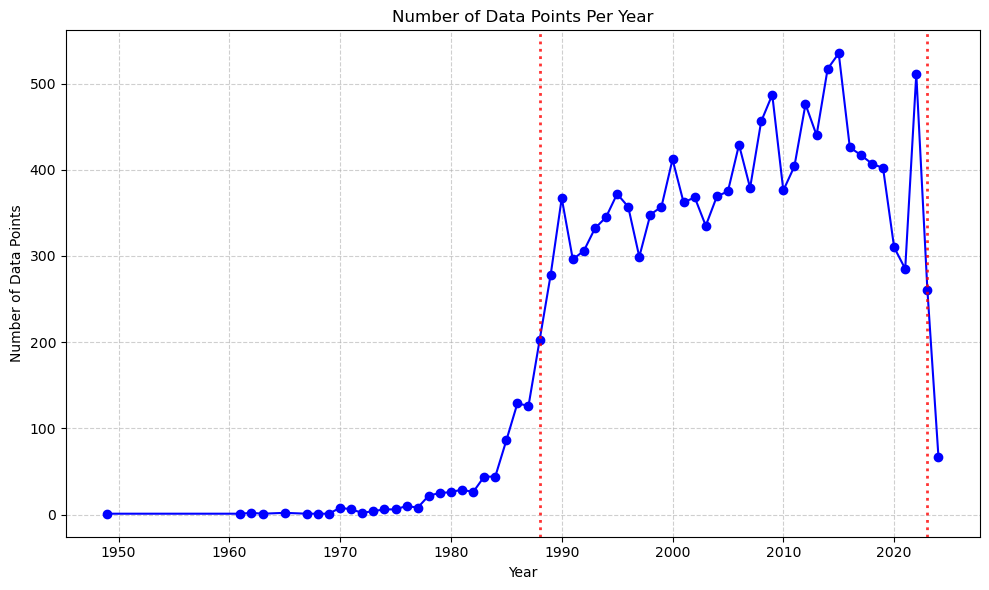

In [214]:

counts = (
    df.groupby('Year of order')
      .size()
      .reset_index(name="n_obs")
      .sort_values('Year of order')

)
counts["se_proxy"] = 1 / np.sqrt(counts["n_obs"])
counts["relative_se"] = (
    counts["se_proxy"] / counts["se_proxy"].min()
)
precision_threshold = 2.0

counts["precise_enough"] = (
    counts["relative_se"] <= precision_threshold
)

precision_year_left = counts.loc[
    counts["precise_enough"], 'Year of order'
].min()

precision_year_right = counts.loc[
    counts["precise_enough"], 'Year of order'
].max()

data_points_per_year = df.groupby('Year of order').size()

# Plot the number of data points per year
plt.figure(figsize=(10, 6))
plt.plot(data_points_per_year.index, data_points_per_year.values, marker='o', linestyle='-', color='blue')
plt.title('Number of Data Points Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Data Points')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axvline(
        x=precision_year_left,
        color='red',
        linestyle=':',
        linewidth=2,
        alpha=0.8
    )
plt.axvline(
        x=precision_year_right,
        color='red',
        linestyle=':',
        linewidth=2,
        alpha=0.8
    )
plt.tight_layout()
plt.savefig('results/data_points_per_year.png', format='png', dpi=300)
plt.show()


df = df[(df['Year of order'] >= precision_year_left) & (df['Year of order'] <= precision_year_right)]



In [215]:
# =========================
# 3. Create Yearly Graphs
# =========================
graphs_by_year = {}
for year, year_df in df.groupby('Year of order'):
    G = nx.DiGraph(year=year)
    for _, row in year_df.iterrows():
        exporter = row['Supplier']
        importer = row['Recipient']
        tiv = row['SIPRI TIV for total order']
        if G.has_edge(exporter, importer):
            G[exporter][importer]['weight'] += tiv
        else:
            G.add_edge(exporter, importer, weight=tiv)
    graphs_by_year[year] = G

# =========================
# 4. Compute Node Features
# =========================
all_features = []
for year, G in graphs_by_year.items():
    for node in G.nodes:
        all_features.append({
            'year': year,
            'country': node,
            'in_degree': G.in_degree(node),
            'out_degree': G.out_degree(node),
            'weighted_in_degree': G.in_degree(node, weight='weight'),
            'weighted_out_degree': G.out_degree(node, weight='weight')
        })

features_df = pd.DataFrame(all_features)

In [216]:
# ===============================
# 5. Build full country–year grid
# ===============================

features_df = (
    features_df
    .set_index(['year', 'country'])
    .reindex(
        pd.MultiIndex.from_product(
            [features_df['year'].unique(),
             features_df['country'].unique()],
            names=['year', 'country']
        )
    )
    .reset_index()
)
# ================================================================
# 6. Rescale years linearly for extra feature in anomaly detection
# ================================================================

features_df['year_scaled'] = MinMaxScaler().fit_transform(features_df[['year']])




In [217]:
# ===================================================================
# 7. Train and fit IsolationForest and LocalOutlierFactor per country
# ===================================================================

feature_cols = [
    'year_scaled',
    'in_degree',
    'out_degree',
    'weighted_in_degree',
    'weighted_out_degree'
]

features_df['iso_anomaly'] = False
features_df['lof_anomaly'] = False

for country, df_c in features_df.groupby('country'):

    df_c = df_c.sort_values('year_scaled')
    df_c = df_c.dropna()
    
    #Continue only if enough data points for each country
    if len(df_c) < 20:
        continue


    X = df_c[feature_cols].values
    transformer = RobustScaler().fit(X)
    X = transformer.transform(X)

    
    # Isolation Forest
    iso = IsolationForest(
        n_estimators=5,
    )
    iso_labels = iso.fit_predict(X)

    # Local Outlier Factor
    lof = LocalOutlierFactor(
        n_neighbors=4,
    )
    
    lof_labels = lof.fit_predict(X)

    # Store results
    features_df.loc[df_c.index, 'iso_anomaly'] = iso_labels == -1
    features_df.loc[df_c.index, 'lof_anomaly'] = lof_labels == -1

In [218]:
####### Nog even goed over nadenken


features_df['anomaly'] = (
    features_df['iso_anomaly'] &
    features_df['lof_anomaly']
)


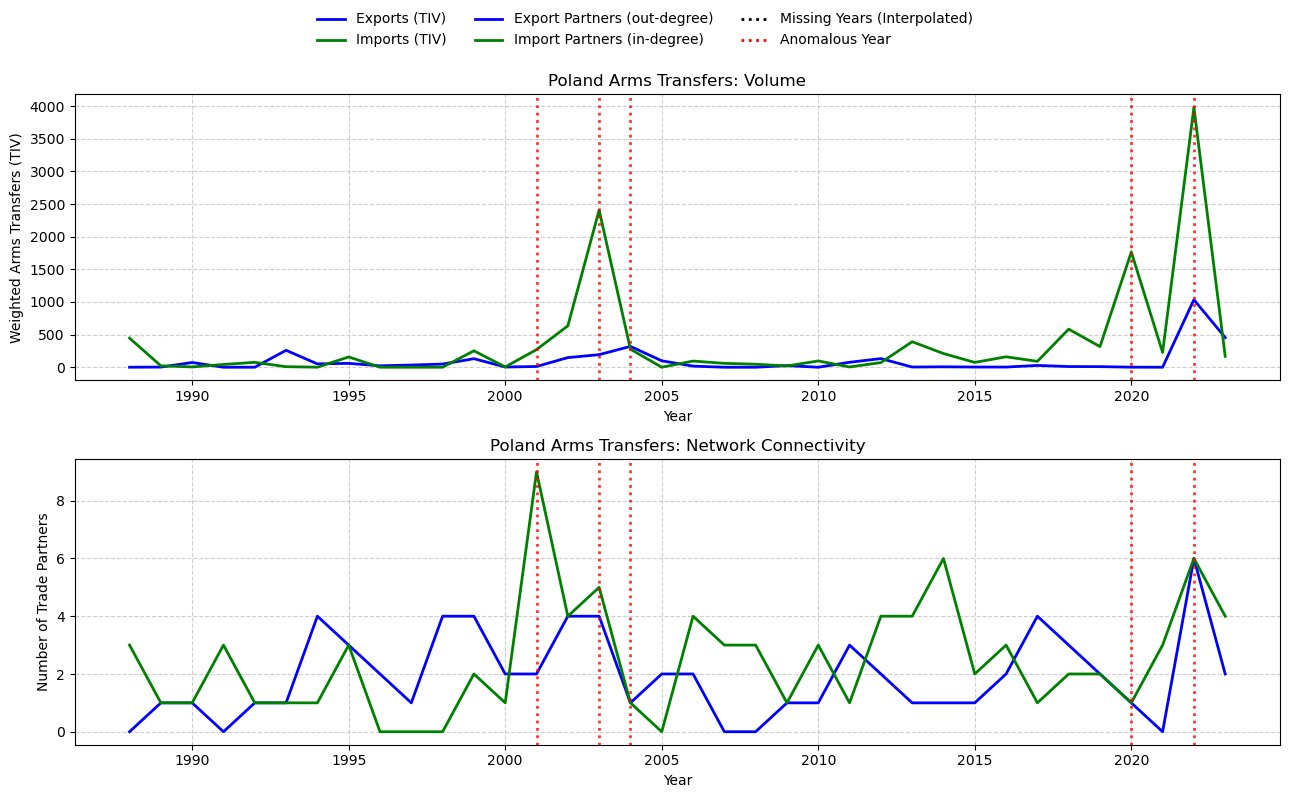

In [220]:

country='Poland'


country_df = (
    features_df[features_df['country'] == country]
    .sort_values('year')
    .set_index('year')
)

# Create full year range to expose missing years
full_years = np.arange(country_df.index.min(), country_df.index.max() + 1)
country_full = country_df.reindex(full_years)

# -------------------------------
# Plot
# -------------------------------
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(13, 8), sharex=True
)

# =========================================================
# TOP: Weighted volumes
# =========================================================
ax1.plot(
    country_full.index,
    country_full['weighted_out_degree'],
    color='blue',
    linewidth=2,
    label='Exports (TIV)'
)

ax1.plot(
    country_full.index,
    country_full['weighted_in_degree'],
    color='green',
    linewidth=2,
    label='Imports (TIV)'
)

for col, color in [
    ('weighted_out_degree', 'blue'),
    ('weighted_in_degree', 'green')
]:
    y = country_full[col]
    valid_idx = np.where(~np.isnan(y.values))[0]

    for i in range(len(valid_idx) - 1):
        idx1, idx2 = valid_idx[i], valid_idx[i + 1]
        if idx2 - idx1 > 1:
            ax1.plot(
                [y.index[idx1], y.index[idx2]],
                [y.iloc[idx1], y.iloc[idx2]],
                color=color,
                linestyle=':',
                linewidth=2,
                alpha=0.8
            )


for year in country_df.loc[country_df['anomaly'], :].index:
    ax1.axvline(
        x=year,
        color='red',
        linestyle=':',
        linewidth=2,
        alpha=0.8
    )

ax1.set_ylabel('Weighted Arms Transfers (TIV)')
ax1.set_title(f'{country} Arms Transfers: Volume')
ax1.set_xlabel('Year')  # Add a label
ax1.tick_params(axis='x', labelbottom=True)  # Show tick labels
# =========================================================
# BOTTOM: Connectivity (degrees)
# =========================================================
ax2.plot(
    country_full.index,
    country_full['out_degree'],
    color='blue',
    linewidth=2,
    label='Export Partners (out-degree)'
)

ax2.plot(
    country_full.index,
    country_full['in_degree'],
    color='green',
    linewidth=2,
    label='Import Partners (in-degree)'
)

# Dotted connectors across missing years
for col, color in [
    ('out_degree', 'blue'),
    ('in_degree', 'green')
]:
    y = country_full[col]
    valid_idx = np.where(~np.isnan(y.values))[0]

    for i in range(len(valid_idx) - 1):
        idx1, idx2 = valid_idx[i], valid_idx[i + 1]
        if idx2 - idx1 > 1:
            ax2.plot(
                [y.index[idx1], y.index[idx2]],
                [y.iloc[idx1], y.iloc[idx2]],
                color=color,
                linestyle=':',
                linewidth=2,
                alpha=0.8
            )

# Same anomaly markers for alignment
for year in country_df.loc[country_df['anomaly'], :].index:
    ax2.axvline(
        x=year,
        color='red',
        linestyle=':',
        linewidth=2,
        alpha=0.8
    )

ax2.set_ylabel('Number of Trade Partners')
ax2.set_xlabel('Year')
ax2.set_title(f'{country} Arms Transfers: Network Connectivity')

# =========================================================
# Legend (shared)
# =========================================================
missing_line = mlines.Line2D(
    [], [], color='black', linestyle=':', linewidth=2,
    label='Missing Years (Interpolated)'
)

anomaly_line = mlines.Line2D(
    [], [], color='red', linestyle=':', linewidth=2,
    label='Anomalous Year'
)

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

handles = handles1 + handles2 + [missing_line, anomaly_line]
labels = labels1 + labels2 + ['Missing Years (Interpolated)', 'Anomalous Year']

fig.legend(
    handles=handles,
    labels=labels,
    loc='upper center',
    ncol=3,
    frameon=False
)

# -------------------------------
# Formatting
# -------------------------------
ax1.grid(True, linestyle='--', alpha=0.6)
ax2.grid(True, linestyle='--', alpha=0.6)
plt.savefig('results/country_anomalies.png')
fig.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

